In [3]:
import sys
sys.path.append('../')

In [4]:
from DPF import ShardsDatasetConfig, DatasetReader

config = ShardsDatasetConfig.from_path_and_columns(
    'example_dataset',
    image_name_col='image_name',
    text_col="caption"
)

reader = DatasetReader()
processor = reader.read_from_config(config)

  0%|          | 0/3 [00:00<?, ?it/s]

## Check dataset samples and summary info

In [5]:
processor.print_summary()

Dataset format: shards
Path: example_dataset
Modalities: ['image', 'text']
Columns: 3
Total samples: 500


In [6]:
processor.df

image_path  \
0      example_dataset/0.tar/0.jpg   
1      example_dataset/0.tar/1.jpg   
2      example_dataset/0.tar/2.jpg   
3      example_dataset/0.tar/3.jpg   
4      example_dataset/0.tar/4.jpg   
..                             ...   
495  example_dataset/2.tar/495.jpg   
496  example_dataset/2.tar/496.jpg   
497  example_dataset/2.tar/497.jpg   
498  example_dataset/2.tar/498.jpg   
499  example_dataset/2.tar/499.jpg   

                                                  text split_name  
0    шотландцы в национальной одежде с флагом. - ba...          0  
1    королевская золотая корона с драгоценностями н...          0  
2                                                Пасха          0  
3    округа нью-джерси карта печати - elizabeth sto...          0  
4    английская золотая корона с драгоценностями, и...          0  
..                                                 ...        ...  
495                                   bokeh Background          2  
496                              Healthcare, Medicine,          2  
497  A set of business teams icons that include edi...          2  
498              Vector floral pattern icon collection          2  
499  Set of Brown ribbons, banners, badges and labe...          2  

[500 rows x 3 columns]

# Filters

## Image info filter

In [7]:
from DPF.filters.images.info_filter import ImageInfoFilter

datafilter = ImageInfoFilter(workers=16)
processor.apply_data_filter(datafilter)

100%|██████████| 500/500 [00:00<00:00, 588.61it/s]


In [8]:
processor.df # new columns is_correct, width, height, channels, error are added

image_path  \
0      example_dataset/0.tar/0.jpg   
1      example_dataset/0.tar/1.jpg   
2      example_dataset/0.tar/2.jpg   
3      example_dataset/0.tar/3.jpg   
4      example_dataset/0.tar/4.jpg   
..                             ...   
495  example_dataset/2.tar/495.jpg   
496  example_dataset/2.tar/496.jpg   
497  example_dataset/2.tar/497.jpg   
498  example_dataset/2.tar/498.jpg   
499  example_dataset/2.tar/499.jpg   

                                                  text split_name  is_correct  \
0    шотландцы в национальной одежде с флагом. - ba...          0        True   
1    королевская золотая корона с драгоценностями н...          0        True   
2                                                Пасха          0        True   
3    округа нью-джерси карта печати - elizabeth sto...          0        True   
4    английская золотая корона с драгоценностями, и...          0        True   
..                                                 ...        ...         ...   
495                                   bokeh Background          2        True   
496                              Healthcare, Medicine,          2        True   
497  A set of business teams icons that include edi...          2        True   
498              Vector floral pattern icon collection          2        True   
499  Set of Brown ribbons, banners, badges and labe...          2        True   

     width  height  channels error  
0      612     612         3  None  
1      612     306         3  None  
2      640     360         3  None  
3      464     612         3  None  
4      612     612         3  None  
..     ...     ...       ...   ...  
495    612     344         3  None  
496    612     612         3  None  
497    612     612         3  None  
498    612     612         3  None  
499    612     612         3  None  

[500 rows x 8 columns]

## PHash filter

In [9]:
from DPF.filters.images.hash_filters import PHashFilter

datafilter = PHashFilter(sim_hash_size=8, workers=16)
processor.apply_data_filter(datafilter)

100%|██████████| 500/500 [00:01<00:00, 391.57it/s]


In [10]:
processor.df['image_phash_8'] # Perceptual hash of images

0      e1f6e7c0e07f0e3d381f8fc07e09c7f0103fe07038ec7918
1      fc3100ffcd0b6301c8ef9f1c0399d8030ebfe38e047db03f
2      effe38e3be07747080a1d9d8fe2fe80081f8ff8c2701f018
3      ec4007e06e0113b7f8f007e603f63f1381d81f8fff027e33
4      e3f1c6ec703ffc01b81b9fc0216e0703efc2fc01b1fa81f0
                             ...                       
495    e431028fcd3581f1e6f073071df63df139c303b3d0f23417
496    fb8efe188cc61869c6187c6618f9c019ec4618fc771c8ff8
497    fc70381c70381c71f81c71f81c70385fbe07e38fc7e38fc0
498    e80f7f080d3c0fc13e0c4770f03ec5f38281f7e1bbe0b1c7
499    fbf03803f03ce001fc1b8fc103fe073c7e38fc01b8e381df
Name: image_phash_8, Length: 500, dtype: object

## ImprovedAestheticFilter (from LAION)

In [11]:
from DPF.filters.images.aesthetic_improved_filter import ImprovedAestheticFilter

datafilter = ImprovedAestheticFilter(
    weights_folder='../weights',  # path to weights folder, will be downloaded to this folder
    device='cuda:0',
    workers=16
)
print(datafilter.result_columns)
processor.apply_data_filter(datafilter)

['improved_aesthetic_score_ViT-L/14']


10it [00:05,  1.95it/s]                      


In [12]:
processor.df['improved_aesthetic_score_ViT-L/14']

0      5.601146
1      4.966230
2      5.068741
3      4.848436
4      5.539761
         ...   
495    5.285481
496    4.501980
497    3.883074
498    5.069400
499    4.538239
Name: improved_aesthetic_score_ViT-L/14, Length: 500, dtype: float64

## CLIPLabelsFilter 

In [13]:
from DPF.filters.images.cliplabels_filter import CLIPLabelsFilter

datafilter = CLIPLabelsFilter(
    clip_model='ViT-L/14',
    labels=['photo of a car', 'photo of a man', 'photo of a dog'],
    weights_folder='../weights', # path to weights folder, will be downloaded to this folder
    device='cuda:0',
    workers=16
)
print(datafilter.result_columns)
processor.apply_data_filter(datafilter)

['ViT-L/14 clip score "photo of a car"', 'ViT-L/14 clip score "photo of a man"', 'ViT-L/14 clip score "photo of a dog"']


10it [00:03,  2.52it/s]                      


In [14]:
colname = 'ViT-L/14 clip score "photo of a dog"'
processor.df[colname]

0      0.049438
1      0.090820
2      0.124451
3      0.110779
4      0.104065
         ...   
495    0.134888
496    0.046631
497    0.003983
498    0.075867
499    0.063782
Name: ViT-L/14 clip score "photo of a dog", Length: 500, dtype: float64

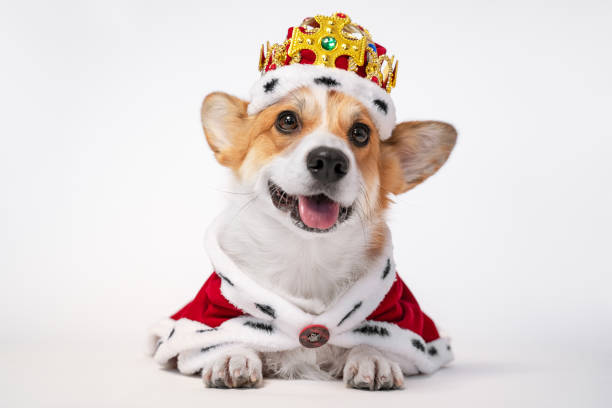

In [15]:
from PIL import Image
import io

m2d, metadata = processor.get_random_sample(processor.df[colname]>0.22)
Image.open(io.BytesIO(m2d['image']))

## WatermarksFilter

In [16]:
from DPF.filters.images.watermarks_filter import WatermarksFilter

datafilter = WatermarksFilter(
    watermarks_model='resnext101_32x8d-large',
    weights_folder='../weights', # path to weights folder, will be downloaded to this folder
    device='cuda:0',
    workers=16
)
print(datafilter.result_columns)
processor.apply_data_filter(datafilter)

/home/jovyan/.mlspace/envs/dpf_llava/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jovyan/.mlspace/envs/dpf_llava/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/jovyan/.mlspace/envs/dpf_llava/lib/python3.11/site-packages/huggingface_hub/file_download.py:669: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(


['watermark_resnext101_32x8d-large']


10it [00:04,  2.42it/s]                      


In [17]:
processor.df['watermark_resnext101_32x8d-large']

0      1
1      0
2      0
3      0
4      0
      ..
495    1
496    1
497    1
498    1
499    1
Name: watermark_resnext101_32x8d-large, Length: 500, dtype: int64

## Text detection

In [7]:
# TODO

# Captioning

## LLaVaCaptioningFilter

In [9]:
from DPF.filters.images.llava_captioning_filter import LLaVaCaptioningFilter

datafilter = LLaVaCaptioningFilter(
    workers=16, 
    prompt='pixart', 
    batch_size=8, 
    device='cuda:0'
)

processor.apply_data_filter(datafilter)

Describe this image and its style in a very detailed manner


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some weights of the model checkpoint at openai/clip-vit-large-patch14-336 were not used when initializing CLIPVisionModel: ['text_model.encoder.layers.8.self_attn.v_proj.bias', 'text_model.encoder.layers.8.layer_norm1.bias', 'text_model.encoder.layers.7.layer_norm1.weight', 'text_model.encoder.layers.4.mlp.fc2.bias', 'text_model.encoder.layers.2.layer_norm2.bias', 'text_model.encoder.layers.3.self_attn.q_proj.weight', 'text_model.encoder.layers.4.self_attn.out_proj.weight', 'text_model.encoder.layers.2.mlp.fc1.bias', 'text_model.encoder.layers.8.self_attn.out_proj.weight', 'text_model.encoder.layers.1.self_attn.v_proj.weight', 'text_model.encoder.layers.2.self_attn.q_proj.weight', 'text_model.encoder.layers.0.mlp.fc2.weight', 'text_model.encoder.layers.0.layer_norm1.bias', 'text_model.encoder.layers.4.self_attn.q_proj.bias', 'text_model.encoder.layers.6.self_attn.q_proj.bias', 'visual_projection.weight', 'text_model.encoder.layers.4.mlp.fc1.weight', 'text_model.encoder.layers.5.layer_n

100%|██████████| 63/63 [09:56<00:00,  9.48s/it]


In [ ]:
processor.df['caption liuhaotian/llava-v1.5-13b prompt pixart']

## BLIP captioning

In [13]:
# from DPF.filters.images.blip_captioning_filter import BLIPCaptioningFilter

# datafilter = BLIPCaptioningFilter(
#     workers=16, 
#     batch_size=32, 
#     device='cuda:0'
# )

# processor.apply_data_filter(datafilter)

# TODO: fix error

In [ ]:
processor.df['blip_caption']